# Packages

In [51]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import geopandas as gpd
import osmnx as ox
import pysal as ps
import mapclassify as mc
from geopandas.tools import geocode
from shapely.geometry import Point, LineString, Polygon

import os
os.getcwd()

'c:\\Users\\gilramolete\\OneDrive - UNIONBANK of the Philippines\\Documents 1\\Geospatial Analysis\\Automating GIS Processes'

# Geocoding in Geopandas

It is possible to do geocoding in Geopandas using its integrated functionalities of geopy. Geopandas has a function called `geocode()` that can geocode a list of addresses (strings) and return a GeoDataFrame containing the resulting point objects in `geometry` column. Nice, isn’t it! Let’s try this out.

In [2]:
# Filepath
fp = 'data/L3/L3_data/addresses.txt'

# Read data
data = pd.read_csv(fp, sep = ';')
data.head()

,id,addr
0,1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [4]:
# Geocode addresses with Nominatim backend
geo = geocode(data['addr'], provider = 'nominatim', user_agent = 'csc_user_ht')
geo.head()

,geometry,address
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns..."
1,POINT (24.93166 60.16905),"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp..."
2,POINT (24.94168 60.16996),"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel..."
3,POINT (24.97783 60.18892),"Hermannin rantatie, Verkkosaari, Kalasatama, S..."
4,POINT (24.92151 60.15662),"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E..."


And Voilà! As a result we have a GeoDataFrame that contains our original address and a `‘geometry’` column containing Shapely Point -objects that we can use for exporting the addresses to a Shapefile for example. However, the `id` column is not there. Thus, we need to join the information from `data` into our new GeoDataFrame `geo`, thus making a Table Join.

## Table Join

Table joins are really common procedures when doing GIS analyses. As you might remember from our earlier lessons, combining data from different tables based on common `key` attribute can be done easily in Pandas/Geopandas using `.merge() -function.

However, sometimes it is useful to join two tables together based on the **index** of those DataFrames. In such case, we assume that there is **same number of records** in our DataFrames and that the **order of the records should be the same** in both DataFrames. In fact, now we have such a situation as we are geocoding our addresses where the order of the geocoded addresses in `geo` DataFrame is the same as in our original `data` DataFrame.

Hence, we can join those tables together with `join()`-function which merges the two DataFrames together based on index by default.

In [5]:
join = geo.join(data)
join.head()

,geometry,address,id,addr
0,POINT (24.91556 60.16320),"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland"
1,POINT (24.93166 60.16905),"Kamppi, 1, Kampinkuja, Kamppi, Eteläinen suurp...",1001,"Kampinkuja 1, 00100 Helsinki, Finland"
2,POINT (24.94168 60.16996),"Bangkok9, 8, Kaivokatu, Keskusta, Kluuvi, Etel...",1002,"Kaivokatu 8, 00101 Helsinki, Finland"
3,POINT (24.97783 60.18892),"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland"
4,POINT (24.92151 60.15662),"9, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",1005,"Tyynenmerenkatu 9, 00220 Helsinki, Finland"


In [6]:
type(join)

geopandas.geodataframe.GeoDataFrame

In [7]:
# Output file path
outfp = 'data/L3/L3_data/addresses.shp'

# Save to shapefile
join.to_file(outfp)

## Notes about Nominatim

Nominatim works relatively nicely if you have well defined and well-known addresses such as the ones that we used in this tutorial. However, in some cases, you might not have such well-defined addresses, and you might have e.g. only the name of a museum available. In such cases, Nominatim might not provide such good results, and in such cases you might want to use e.g. Google Geocoding API (V3).

# Retrieving OpenStreetMap data

## What is OSM?

OpenStreetMap (OSM) is a **global collaborative (crowd-sourced) dataset and project that aims at creating a free editable map of the world** containing a lot of information about our environment. It contains data for example about streets, buildings, different services, and landuse to mention a few.

OSM has a large userbase with more than 4 million users that contribute actively on OSM by updating the OSM database with 3 million changesets per day. In total OSM contains more than 4 billion nodes that form the basis of the digitally mapped world that OSM provides (stats from November 2017.

OpenStreetMap is used not only for integrating **the OSM maps** as background maps to visualizations or online maps, but also for many other purposes such as **routing, geocoding, education**, and **research**. OSM is also widely used for humanitarian response e.g. in crisis areas (e.g. after natural disasters) and for fostering economic development.

## `osmnx`

This week we will explore a nice Python module called osmnx that can be used to retrieve, construct, analyze, and visualize street networks from OpenStreetMap. In short it offers really handy functions to download data from OpenStreet map, analyze the properties of the OSM street networks, and conduct network routing based on walking, cycling or driving.

Let’s see how we can download and visualize street network data from a district of Kamppi in Helsinki, Finland. Osmnx makes it really easy to do that as it allows you to specify an address to retrieve the OpenStreetMap data around that area. In fact, osmnx uses the same Nominatim Geocoding API to achieve this which we tested during the previous tutorial.

Let’s retrieve OpenStreetMap (OSM) data by specifying `"Kamppi, Helsinki, Finland"` as the address where the data should be downloaded:

In [9]:
# Specify the name that is used to seach for the data
place_name = "Kamppi, Helsinki, Finland"

# Fetch OSM street network from the location
graph = ox.graph_from_place(place_name)
type(graph)

networkx.classes.multidigraph.MultiDiGraph

As we can see, the data that we retrieved is a special data object called `networkx.classes.multidigraph.MultiDiGraph`. A DiGraph is a data type that stores nodes and edges with optional data, or attributes. What we can see here is that this data type belongs to a Python module called networkx that can be used to create, manipulate, and study the structure, dynamics, and functions of complex networks. Networkx module contains algorithms that can be used to calculate shortest paths along road networks using e.g. Dijkstra’s or A* algorithm.

Let’s see how our street network looks like. It is easy to visualize the graph with osmnx with `plot_graph()` function. The function utilizes Matplotlib for visualizing the data, hence as a result it returns a matplotlib figure and axis objects:

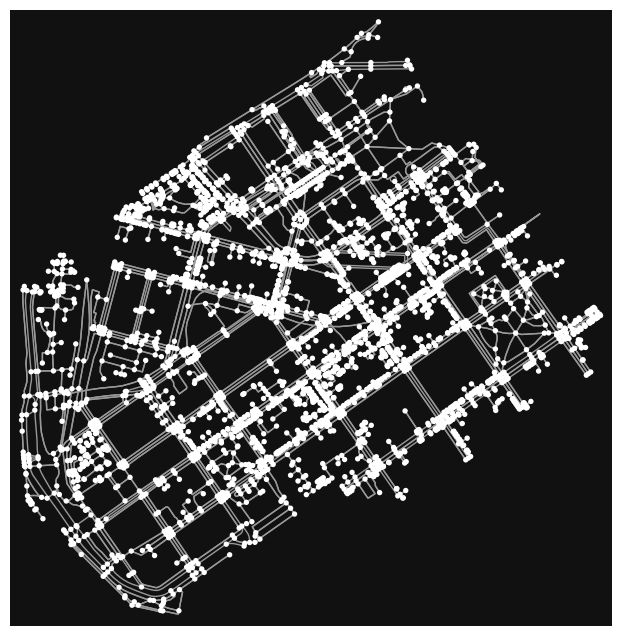

In [10]:
# Plot the streets
fig, ax = ox.plot_graph(graph)
plt.show()

Great! Now we can see that our graph contains the nodes (blue circles) and the edges (gray lines) that connects those nodes to each other.

It is also possible to retrieve other types of OSM data features with osmnx such as buildings or points of interest (POIs).

Let’s download the buildings with `buildings_from_place()`-function and plot them on top of our street network in Kamppi. Let’s also plot the Polygon that represents the area of Kamppi, Helsinki that can be retrieved with `gdf_from_place`-function.

In [27]:
# Retrieve the footprint of our location
area = ox.geocode_to_gdf(place_name)

# Retrieve buildings from the area
buildings = ox.geometries_from_place(place_name, tags = {'building': True})

print(type(area), type(buildings))

<class 'geopandas.geodataframe.GeoDataFrame'> <class 'geopandas.geodataframe.GeoDataFrame'>


In [28]:
# Retrieve restaurants
restaurants = ox.geometries_from_place(place_name, tags = {'amenity': 'restaurant'})

# How many restaurants do we have?
len(restaurants)

174

In [29]:
restaurants.columns

Index(['addr:city', 'addr:country', 'addr:housenumber', 'addr:postcode',
       'addr:street', 'amenity', 'cuisine', 'diet:halal', 'diet:kosher',
       'name', 'payment:credit_cards', 'payment:debit_cards', 'phone',
       'website', 'wheelchair', 'geometry', 'email', 'facebook',
       'opening_hours', 'short_name', 'start_date', 'toilets:wheelchair',
       'delivery:covid19', 'opening_hours:covid19', 'takeaway:covid19',
       'diet:vegetarian', 'name:fi', 'name:zh', 'description', 'diet:vegan',
       'contact:phone', 'contact:website', 'source', 'outdoor_seating',
       'addr:housename', 'level', 'address', 'access:covid19',
       'drive_through:covid19', 'takeaway', 'delivery', 'url', 'lunch:menu',
       'note', 'reservation', 'room', 'contact:facebook', 'indoor_seating',
       'opening_hours:brunch', 'toilets', 'capacity', 'smoking', 'access:dog',
       'operator', 'shop', 'alt_name', 'contact:email', 'established',
       'diet:non-vegetarian', 'name:sv', 'drive_through',

In [30]:
# Select some useful cols and print
cols = ['name', 'opening_hours', 'addr:city', 'addr:country', 'addr:housenumber',
    'addr:postcode', 'addr:street']

restaurants[cols].head(10)

name  \
element_type osmid                                 
node         60062502                     Kabuki   
             62965963    Restaurant & Bar Fusion   
             76617692               Johan Ludvig   
             76624339                    Shinobi   
             76624351                     Pueblo   
             89074039                Papa Albert   
             151006260           Ravintola China   
             151006483  Tony's deli + Street Bar   
             151006932                Haru Sushi   
             151007074                      Koto   

                                                            opening_hours  \
element_type osmid                                                          
node         60062502                                                 NaN   
             62965963                  Mo-Th 11-22; Fr-Sa 11-02; Su 12-20   
             76617692                                                 NaN   
             76624339                                                 NaN   
             76624351                                                 NaN   
             89074039   Mo-Th 10:00-14:00, 17:30-22:00; Fr 11:00-23:00...   
             151006260       Mo-Fr 11:00-23:00; Sa-Su 12:00-23:00; PH off   
             151006483                                                NaN   
             151006932  Mo-Fr 11:00-21:00; Sa 12:00-21:00; Su 13:00-21:00   
             151007074                                                NaN   

                       addr:city addr:country addr:housenumber addr:postcode  \
element_type osmid                                                             
node         60062502   Helsinki           FI               12         00180   
             62965963        NaN          NaN              NaN           NaN   
             76617692   Helsinki           FI              NaN           NaN   
             76624339   Helsinki           FI               38         00120   
             76624351   Helsinki           FI              NaN           NaN   
             89074039   Helsinki           FI               30         00120   
             151006260  Helsinki           FI               25         00100   
             151006483  Helsinki           FI                7         00120   
             151006932  Helsinki           FI               30         00120   
             151007074  Helsinki           FI               22         00120   

                            addr:street  
element_type osmid                       
node         60062502   Lapinlahdenkatu  
             62965963               NaN  
             76617692               NaN  
             76624339      Albertinkatu  
             76624351       Eerikinkatu  
             89074039      Albertinkatu  
             151006260        Annankatu  
             151006483        Bulevardi  
             151006932    Fredrikinkatu  
             151007074    Lönnrotinkatu

As we can see, there exists a lot of useful information about restaurants that can be retrieved easily with OSMnx.

We can now plot all these different OSM layers by using the familiar `plot()` function of Geopandas. As you might remember, the street network data was not in GeoDataFrame format (it was `networkx.MultiDiGraph`). Luckily, osmnx provides a convenient function `graph_to_gdfs()` that can convert the graph into two separate GeoDataFrames where the first one contains the information about the nodes and the second one about the edge.

Let’s extract the nodes and edges from the graph as GeoDataFrames:

In [31]:
# Retrieve nodes and edges
nodes, edges = ox.graph_to_gdfs(graph)
print('Nodes:\n', nodes.head())
print('\nEdges:\n', edges.head())
print('\nType:', type(edges))

Nodes:
                   y          x  street_count   highway  ref  \
osmid                                                         
25216594  60.164794  24.921057             5       NaN  NaN   
25238874  60.163665  24.921028             4       NaN  NaN   
25238883  60.163452  24.921441             4  crossing  NaN   
25238933  60.161114  24.924529             3       NaN  NaN   
25238937  60.160860  24.925861             3       NaN  NaN   

                           geometry  
osmid                                
25216594  POINT (24.92106 60.16479)  
25238874  POINT (24.92103 60.16366)  
25238883  POINT (24.92144 60.16345)  
25238933  POINT (24.92453 60.16111)  
25238937  POINT (24.92586 60.16086)  

Edges:
                              osmid  oneway lanes            name   highway  \
u        v          key                                                      
25216594 1372425721 0     23717777    True     2   Porkkalankatu   primary   
         1372425714 0     23856784    Tru

Nice! Now, as we can see, we have our graph as GeoDataFrames and we can plot them using the same functions and tools as we have used before.

Note: There are also other ways of retrieving the data from OpenStreetMap with osmnx such as passing a Polygon to extract the data from that area, or passing a Point coordinates and retrieving data around that location with specific radius. Take a look of this tutorial to find out how to use those features of osmnx.

Let’s create a map out of the streets, buildings, restaurants, and the area Polygon but let’s exclude the nodes (to keep the figure clearer).

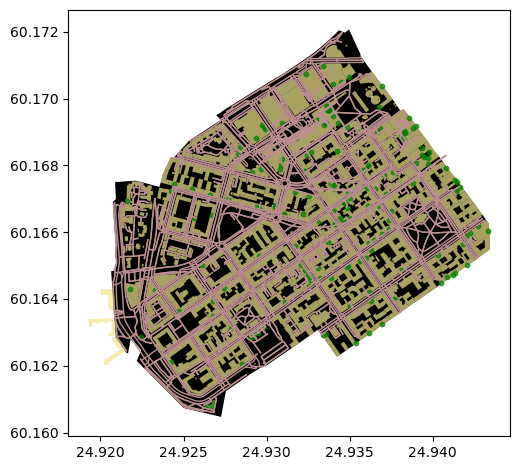

In [33]:
# Plot the footprint
ax = area.plot(facecolor = 'black')

# Plot street edges
edges.plot(ax = ax, linewidth = 1, edgecolor = '#BC8F8F')

# Plot buildings
buildings.plot(ax = ax, facecolor = 'khaki', alpha = 0.70)

# Plot restaurants
restaurants.plot(ax = ax, color = 'green', alpha = 0.70, markersize = 10)

plt.tight_layout()
plt.show()

# Data Reclassification

In this tutorial, we will use Travel Time Matrix data from Helsinki to classify some features of the data based on map classifiers that are commonly used e.g. when doing visualizations, and our own self-made classifier where we determine how the data should be classified.
1. Use ready made classifiers from pysal -module to classify travel times into multiple classes.
2. Use travel times and distances to find out
    - Good locations to buy an apartment with good public transport accessibility to city center
    - But from a bit further away from city center where the prices are presumably lower.

## Classification based on common classifiers

Pysal is an extensive Python library including various functions and tools to do spatial data analysis. It also includes all of the most common data classifiers that are used commonly e.g. when visualizing data. Available map classifiers in `pysal` are (see here for more details):
- Box_Plot
- Equal_Interval
- Fisher_Jenks
- Fisher_Jenks_Sampled
- HeadTail_Breaks
- Jenks_Caspall
- Jenks_Caspall_Forced
- Jenks_Caspall_Sampled
- Max_P_Classifier
- Maximum_Breaks
- Natural_Breaks
- Quantiles
- Percentiles
- Std_Mean
- User_Defined

In [36]:
fp = 'data/L3/L3_data/TravelTimes_to_5975375_RailwayStation_Helsinki.geojson'

# Read the GeoJSON file
acc = gpd.read_file(fp)
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,pt_r_tt,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,area,geometry
0,15981,36,15988,41,6002702,14698,65,73,14698,61,72,5975375,14456,207,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((391000.00013 6667750.00004, 390750.0..."
1,16190,34,16197,39,6002701,14661,64,73,14661,60,72,5975375,14419,206,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((390750.00013 6668000.00004, 390750.0..."
2,15727,33,15733,37,6001132,14256,59,69,14256,55,62,5975375,14014,200,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((391000.00013 6668000.00004, 390750.0..."
3,15975,33,15982,37,6001131,14512,62,73,14512,58,70,5975375,14270,204,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((390750.00013 6668000.00004, 390500.0..."
4,16136,35,16143,40,6001138,14730,65,73,14730,61,72,5975375,14212,203,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((392500.00013 6668000.00004, 392250.0..."


As we can see, there exist plenty of different variables (see from here the description for all attributes) but what we are interested in are columns called `pt_r_tt` which is telling the time in minutes that it takes to reach city center from different parts of the city, and `walk_d` that tells the network distance by roads to reach city center from different parts of the city (almost equal to Euclidian distance).

The NoData values are presented with value -1, thus we need to remove the No Data values first.

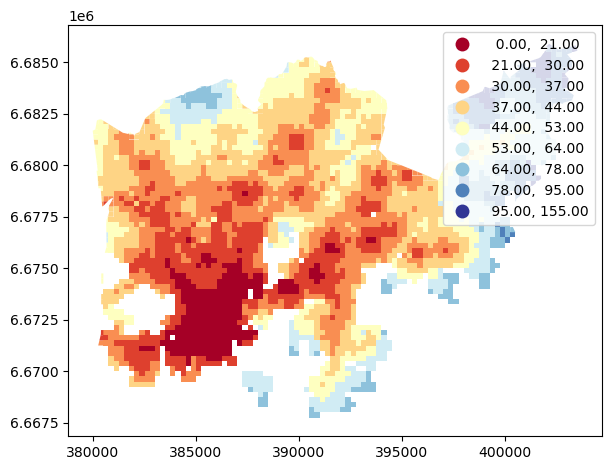

In [39]:
# Include only data that is above or equal to 0
acc = acc.loc[acc['pt_r_tt'] >= 0]

# Plot using 9 classes and classify the values using 'Fisher-Jenks' classification
acc.plot(column = 'pt_r_tt', scheme = 'Fisher_Jenks', k = 9, cmap = 'RdYlBu', linewidth = 0.5, legend = True, aspect = 1)

plt.tight_layout()
plt.show()

As we can see from this map, the travel times are lower in the south where the city center is located but there are some areas of “good” accessibility also in some other areas (where the color is red).

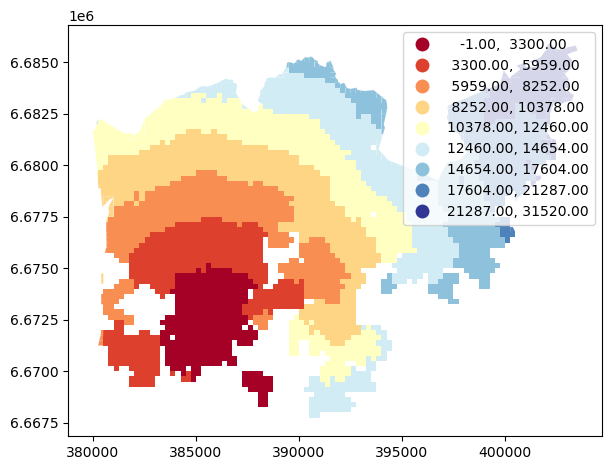

In [40]:
# Plot walking distance
acc.plot(column = 'walk_d', scheme = 'Fisher_Jenks', k = 9, cmap = 'RdYlBu', linewidth = 0.5, legend = True, aspect = 1)

plt.tight_layout()
plt.show()

Okay, from here we can see that the walking distances (along road network) reminds more or less Euclidian distances.

Let’s apply one of the `Pysal` classifiers into our data and classify the travel times by public transport into 9 classes. The classifier needs to be initialized first with `make()` function that takes the number of desired classes as input parameter.

In [54]:
# Define the number of classes
n_classes = 9

# Create a Natural Breaks Classifier
classifier = mc.NaturalBreaks.make(k = n_classes)

# Classify the data
classifications = acc[['pt_r_tt']].apply(classifier)
classifications.head()

,pt_r_tt
0,6
1,6
2,5
3,6
4,6


In [55]:
# Rename the columns so that we know that it was classified with natural breaks
classifications.columns = ['nb_pt_r_tt']

# Join with our original data
acc = acc.join(classifications)
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,...,to_id,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,area,geometry,nb_pt_r_tt
0,15981,36,15988,41,6002702,14698,65,73,14698,61,...,5975375,14456,207,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((391000.00013 6667750.00004, 390750.0...",6
1,16190,34,16197,39,6002701,14661,64,73,14661,60,...,5975375,14419,206,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((390750.00013 6668000.00004, 390750.0...",6
2,15727,33,15733,37,6001132,14256,59,69,14256,55,...,5975375,14014,200,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((391000.00013 6668000.00004, 390750.0...",5
3,15975,33,15982,37,6001131,14512,62,73,14512,58,...,5975375,14270,204,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((390750.00013 6668000.00004, 390500.0...",6
4,16136,35,16143,40,6001138,14730,65,73,14730,61,...,5975375,14212,203,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((392500.00013 6668000.00004, 392250.0...",6


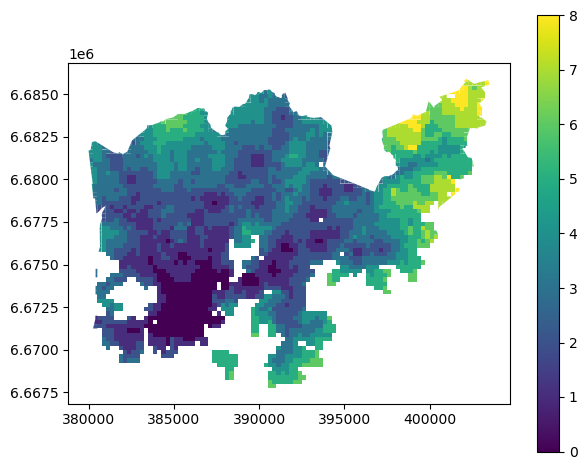

In [57]:
acc.plot(column = 'nb_pt_r_tt', linewidth = 1, legend = True, aspect = True)

plt.tight_layout()
plt.show()

## Creating a custom classifier

Let’s create a function where we classify the geometries into two classes based on a given `threshold`-parameter. If the area of a polygon is lower than the threshold value (average size of the lake), the output column will get a value 0, if it is larger, it will get a value 1. This kind of classification is often called a binary classification.

First we need to create a function for our classification task. This function takes a single row of the GeoDataFrame as input, plus few other parameters that we can use.

It also possible to do classifiers with multiple criteria easily in Pandas/Geopandas by extending the example that we started earlier. Now we will modify our binaryClassifier function a bit so that it classifies the data based on two columns.

In [58]:
def custom_classifier(row, src_col1, src_col2, threshold1, threshold2, output_col):
    # 1. If the value in src_col1 is LOWER than threshold1 value
    # 2. AND the value in src_col2 is HIGHER than the threshold2 value, give value 1, otherwise give 0
    if row[src_col1] < threshold1 and row[src_col2] > threshold2:
        # Update the output column with value 1
        row[output_col] = 1
    # If area of input geometry is higher than the threshold value, update with value 0
    else:
        row[output_col] = 0
    
    return row

Now we have defined the function, and we can start using it. Let’s do our classification based on two criteria and find out grid cells where the travel time is lower or equal to 20 minutes but they are further away than 4 km (4000 meters) from city center.

In [59]:
# Create column for classification results
acc['suitable_area'] = None

# Use the function
acc = acc.apply(custom_classifier, src_col1 = 'pt_r_tt', src_col2 = 'walk_d',
                threshold1 = 20, threshold2 = 4000, output_col = 'suitable_area', axis = 1)
acc.head()

,car_m_d,car_m_t,car_r_d,car_r_t,from_id,pt_m_d,pt_m_t,pt_m_tt,pt_r_d,pt_r_t,...,walk_d,walk_t,GML_ID,NAMEFIN,NAMESWE,NATCODE,area,geometry,nb_pt_r_tt,suitable_area
0,15981,36,15988,41,6002702,14698,65,73,14698,61,...,14456,207,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((391000.00013 6667750.00004, 390750.0...",6,0
1,16190,34,16197,39,6002701,14661,64,73,14661,60,...,14419,206,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((390750.00013 6668000.00004, 390750.0...",6,0
2,15727,33,15733,37,6001132,14256,59,69,14256,55,...,14014,200,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((391000.00013 6668000.00004, 390750.0...",5,0
3,15975,33,15982,37,6001131,14512,62,73,14512,58,...,14270,204,27517366,Helsinki,Helsingfors,091,62499.999976,"POLYGON ((390750.00013 6668000.00004, 390500.0...",6,0
4,16136,35,16143,40,6001138,14730,65,73,14730,61,...,14212,203,27517366,Helsinki,Helsingfors,091,62499.999977,"POLYGON ((392500.00013 6668000.00004, 392250.0...",6,0


In [60]:
acc['suitable_area'].value_counts()

0    3808
1       9
Name: suitable_area, dtype: int64

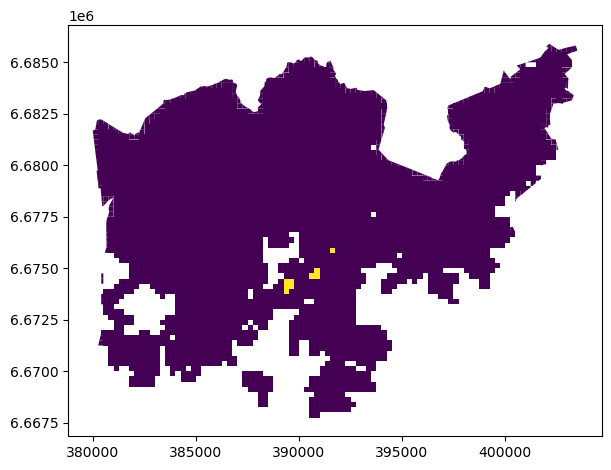

In [62]:
acc.plot(column = 'suitable_area', linewidth = 2, aspect = True)
plt.tight_layout()
plt.show()